#Data Processing and Feature Selection
To prepare the data for model training, the following preprocessing steps were performed:

The trend component was removed

The time series was made stationary using differencing

Lagged (shifted) values were added to capture seasonality

The data was scaled to standardize feature magnitudes using Robust Scaler

Feature Variables:
The features were transformed using differencing to ensure stationarity and reduce the influence of trends

The features were standardized using Robust Scaler

Feature selection was performed to retain the most relevant variables for modeling using SelectKBest and PCA methods

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from google.colab import drive
import json
import base64
import joblib

In [2]:
RANDOMSTATE = 1234
#link to GitHub repo where stock price is saved
TARGET_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/row_datasets/target.csv'
TARGET_FILE_NAME = 'target.csv'
##link to GitHub repo where macroeconomics indicators are saved
FEATURE_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/row_datasets/features.csv'
FEATURE_FILE_NAME = 'features.csv'

In [3]:
#geting data from url and saves it locally
def get_data(url, file_name):
  response = requests.get(url)

#Check if the request was successful
  if response.status_code == 200:
      # Save the file locally
      with open(file_name, "wb") as file:
          file.write(response.content)
      print(f"File downloaded successfully: {file_name}")
      return file_name
  else:
    print(f"Failed to download file: {file_name} Status code: {response.status_code}")
    return None

In [4]:
# Uploads the processed dataset to a GitHub repository
def upload_file(file_path, github_file_path):
    # Generate the GitHub API URL
    url = f"https://api.github.com/repos/{REPO_OWNER}/{REPO_NAME}/contents/{github_file_path}"
    headers = {"Authorization": f"token {github_token}", "Accept": "application/vnd.github.v3+json"}
    # Check if the file already exists in the repository
    response_sha = requests.get(url, headers=headers)

    # Prepare request payload
    data = {
        "message": "Updated CSV-file",
        "content": "",
        "branch": "main"
    }
    # If file exists, include the SHA for an update
    if response_sha.status_code == 200:
        sha = response_sha.json()["sha"]
        data["sha"] = sha
    else:
        print(f"Error getting SHA: {response_sha.json()}")
        exit(1)

    # Read and encode the file in base64
    with open(file_path, "rb") as file:
        data['content'] = base64.b64encode(file.read()).decode("utf-8")


    # Upload or update the file via GitHub API
    response = requests.put(url, json=data, headers=headers)

    if response.status_code == 201:
        print("A new file has been uploaded succesfully")
    elif response.status_code == 200:
        print("An existing file has been updated succesfully")
    else:
        print(f"Error: {response.status_code} - {response.json()}")

In [5]:
# Mount Google Drive to download GitHub token
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#json file contains my github token to push files in repo
CONFIG_PATH = "/content/drive/My Drive/config.json"
#repo owner
REPO_OWNER = "EvgeniyStrizhak"
#repo name
REPO_NAME = "My-master-s-thesis"

In [7]:
# Load GitHub token from a configuration file stored on Google Drive
with open(CONFIG_PATH) as f:
    config = json.load(f)
    github_token = config.get("GITHUB_TOKEN")

if github_token:
    print("GitHub token loaded successfully!")
else:
    print("Error: GitHub token not found!")

GitHub token loaded successfully!


In [8]:
#Download preprocessed data from GitHub
get_data(TARGET_URL, TARGET_FILE_NAME)
get_data(FEATURE_URL, FEATURE_FILE_NAME)

File downloaded successfully: target.csv
File downloaded successfully: features.csv


'features.csv'

In [9]:
#Create a dataframe
target = pd.read_csv('target.csv')
features = pd.read_csv('features.csv')
df = pd.merge(target, features, on=['year', 'month', 'quarter'], how='inner')

##Transforming Time Series into Stationary Data

In [10]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

In [11]:
#substract previous value from current value exept year, month and quarter
df_change = df[['date', '^GDAXI']].copy()
for i in df.columns[:-1]:
    df_change[i] = df[i] - df[i].shift(1)

df_change = df_change.dropna()
df_change = df_change.drop(['year', 'month', 'quarter'], axis=1)
df_change['year'] = df_change['date'].dt.year
df_change['month'] = df_change['date'].dt.month
df_change['quarter'] = df_change['date'].dt.quarter

The relationship between stock prices and macroeconomic indicators after alterations.

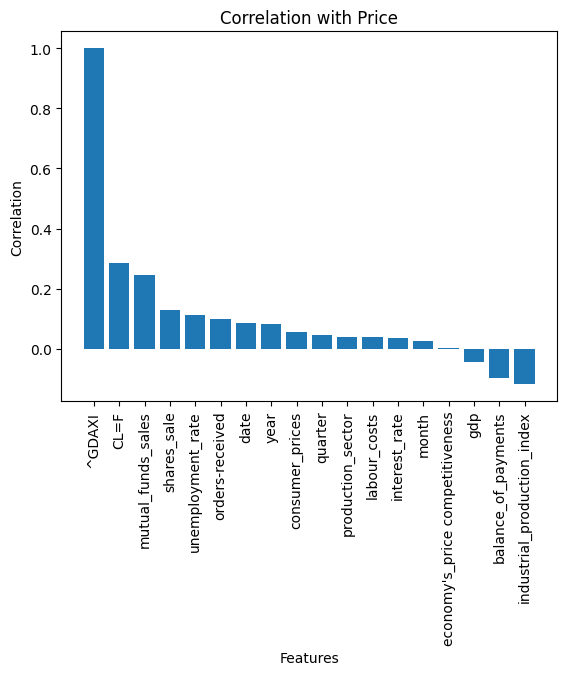

In [12]:
corr_change = df_change.corr()['^GDAXI'].sort_values(ascending=False)
plt.bar(corr_change.index, corr_change.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Correlation with Price')
plt.show()

After preprocessing, the relationship between stock prices and macroeconomic indicators was reevaluated. By removing the trend component, strong correlations between features and the target variable were significantly reduced. This confirms that many macroeconomic indicators only appeared strongly correlated due to the shared upward trend.

Adding Seasonality Components to Features

In [13]:
df_change['lag'] = df_change['^GDAXI'].shift(1)
df_change['lag_2'] = df_change['^GDAXI'].shift(12)
df_change = df_change.dropna()

Based on the data analysis, the GDAXI index follows an annual economic cycle of approximately 12 months. To capture this behavior, lagged features representing seasonality were added to the dataset.

Stationarity Summary

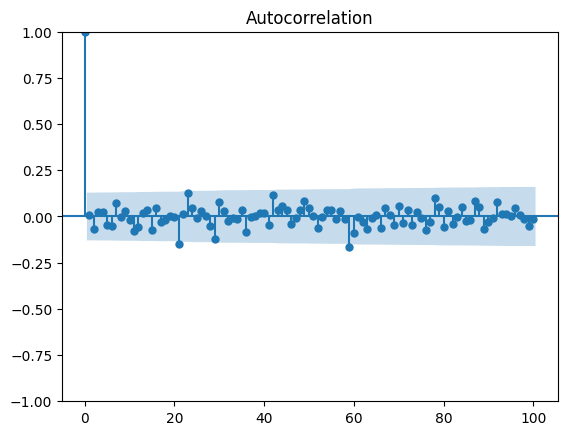

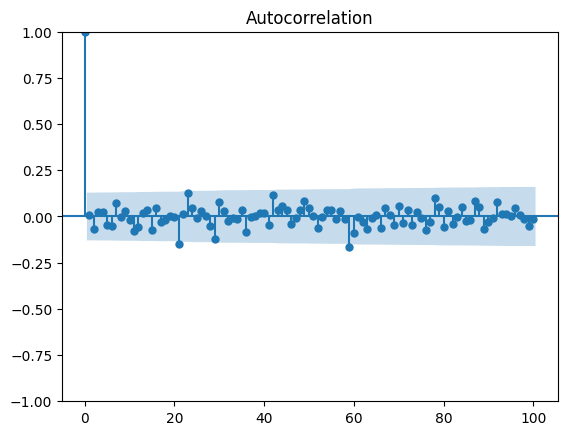

In [14]:
plot_acf(df_change['^GDAXI'], lags=100)

All autocorrelation values beyond lag 0 lie within the 95% confidence interval.

This indicates the absence of statistically significant autocorrelation at higher lags.

No clear decay pattern is observed, and no seasonality remains.

Therefore, the GDAXI index has been successfully differenced, and both trend and seasonality components have been removed, confirming that the series is now stationary.

##Data Splitting

In [15]:
#selecing features by deleting target and turn "data" column into index
features = df_change.drop(['^GDAXI'], axis=1)
features['time'] = features.index
features = features.set_index(['date'])
target = df_change[['^GDAXI', 'date']]
target = target.set_index(['date'])

In [16]:
#list of features
print(features.columns)

Index(['production_sector', 'gdp', 'consumer_prices',
       'industrial_production_index', 'interest_rate',
       'economy's_price competitiveness', 'unemployment_rate', 'labour_costs',
       'mutual_funds_sales', 'orders-received', 'balance_of_payments',
       'shares_sale', 'CL=F', 'year', 'month', 'quarter', 'lag', 'lag_2',
       'time'],
      dtype='object')


In [17]:
#splitting data to train and test samples
#Because data is timeseries parameter "shuffle" set "False"
features_train, features_test = train_test_split(features, test_size=0.06, shuffle=False)
target_train, target_test = train_test_split(target, test_size=0.06, shuffle=False)
print('features_train shape:', features_train.shape)
print('features_test shape:', features_test.shape)
print('target_train shape:', target_train.shape)
print('target_test shape:', target_test.shape)

features_train shape: (216, 19)
features_test shape: (14, 19)
target_train shape: (216, 1)
target_test shape: (14, 1)


The dataset was split into training and testing sets to evaluate model performance on unseen data. This is essential for validating the generalization capability of the model.

##Data Scaling

In [18]:
#Robust scaler is perfect for timeseries data because minimum and maximum values potentially can be higher in the future
#feature scaling
scaler_features = RobustScaler()

scaled_features_train = scaler_features.fit_transform(features_train)
#tranform test values to not allow data leakage
scaled_features_test = scaler_features.transform(features_test)

#target scaling
scaler_target = RobustScaler()
target_train_2d = target_train.values.reshape(-1, 1)
target_test_2d = target_test.values.reshape(-1, 1)

scaled_target_train = scaler_target.fit_transform(target_train_2d)
#tranform test values to not allow data leakage
scaled_target_test = scaler_target.transform(target_test_2d)

All features were scaled to ensure consistent magnitudes, which is particularly important for distance-based and regularization-based machine learning algorithms

##Feature Selection

Two methods were used to identify the most relevant features:

SelectKBest: Chose the top 15 features based on univariate statistical tests.

In [19]:
selector = SelectKBest(score_func=f_regression, k=15)
X_new = selector.fit_transform(scaled_features_train, scaled_target_train.flatten())

selected_mask = selector.get_support()
#apply the filter
scaled_features_train_filtered = scaled_features_train[:, selected_mask]
scaled_features_test_filtered = scaled_features_test[:, selected_mask]
print("Selected features:", selected_mask)

Selected features: [ True  True  True  True  True False  True False  True  True  True  True
  True False  True  True False  True  True]


PCA (Principal Component Analysis): Reduced the feature set to the 10 most informative principal components, capturing the majority of the variance in the dataset.

In [20]:
pca = PCA(n_components=10)

scaled_features_train_pca = pca.fit_transform(scaled_features_train_filtered)

# Apply the same PCA transformation to the test data
scaled_features_test_pca = pca.transform(scaled_features_test_filtered)

##Data uploading

In [21]:
#Upload the final target dataset to GitHub
github_file_path = 'processed_datasets/features_train.csv'
file_path = 'features_train.csv'
features_train_csv = pd.DataFrame(scaled_features_train_filtered)
features_train_csv.index = features_train.index
features_train_csv.to_csv(file_path)
upload_file(file_path, github_file_path)

An existing file has been updated succesfully


In [22]:
#Upload the final target dataset to GitHub
github_file_path = 'processed_datasets/features_test.csv'
file_path = 'features_test.csv'
features_test_csv = pd.DataFrame(scaled_features_test_filtered)
features_test_csv.index = features_test.index
features_test_csv.to_csv(file_path)
upload_file(file_path, github_file_path)

An existing file has been updated succesfully


In [23]:
#Upload the final target dataset to GitHub
github_file_path = 'processed_datasets/target_train.csv'
file_path = 'target_train.csv'
target_train_csv = pd.DataFrame(scaled_target_train)
target_train_csv.index = target_train.index
target_train_csv.to_csv(file_path)
upload_file(file_path, github_file_path)

An existing file has been updated succesfully


In [24]:
#Upload the final target dataset to GitHub
github_file_path = 'processed_datasets/target_test.csv'
file_path = 'target_test.csv'
target_test_csv = pd.DataFrame(scaled_target_test)
target_test_csv.index = target_test.index
target_test_csv.to_csv(file_path)
upload_file(file_path, github_file_path)

An existing file has been updated succesfully


In [25]:
#Upload scaler for features to GitHub
github_file_path = 'processed_datasets/scaler_features.save'
file_path = 'scaler_features.save'
joblib.dump(scaler_features, file_path)
upload_file(file_path, github_file_path)

An existing file has been updated succesfully


In [26]:
#Upload scaler for target to GitHub
github_file_path = 'processed_datasets/scaler_target.save'
file_path = 'scaler_target.save'
joblib.dump(scaler_target, file_path)
upload_file(file_path, github_file_path)

An existing file has been updated succesfully


The final, preprocessed dataset—including stationary target and selected features—was uploaded for training and evaluation.